# Webscrapping using BeautifulSoup

by S.Y. Husada

## Background

At this project I try to scrap Ethereum sales volume from coingecko website. Coingecko was founded with the mission to democratize the access of crypto data and empower users with actionable insights. I will scrap 2 key values from this site. First is **Date**, the second one is **Volume**.  

## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [62]:
import requests

url_get = requests.get('https://www.coingecko.com/en/coins/ethereum/historical_data/usd?start_date=2020-01-01&end_date=2021-06-30#panel')

Let's use `.content` attribute to take a peek at what I received from the site.

In [63]:
url_get.content[1:200]

b'!DOCTYPE html>\n<html lang="en">\n<head>\n<script async defer src="https://www.googleoptimize.com/optimize.js?id=GTM-W3CD992"></script>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content='

Those jumble of mess contains the codes needed to show the webpage on browser. With BeautifulSoup, it's possible to convert that mess into more manageable 'beautifulsoup' object in Python; it consists of a complex tree of Python objects. 

To do that, let's import BeautifulSoup from bs4 and assign the content to a beautifulsoup object called "soup".

In [64]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")

## Finding the right key to scrap the data & Extracting the right information

Let's identify the right tags from the soup to scrap Date and Volume. 
To do such tasks, I can use  `.find()` on the soup object. 

In [65]:
table = soup.find('table', attrs={'class':'table table-striped text-sm text-lg-normal'})
print(table.prettify()[1:500])

table class="table table-striped text-sm text-lg-normal">
 <thead>
  <tr>
   <th class="text-center">
    Date
   </th>
   <th class="text-center">
    Market Cap
   </th>
   <th class="text-center">
    Volume
   </th>
   <th class="text-center">
    Open
   </th>
   <th class="text-center">
    Close
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <th class="font-semibold text-center" scope="row">
    2021-06-30
   </th>
   <td class="text-center">
    $253,607,549,372
   </td>
   <td class="te


As shown in the ouput above, Date is in 'th' tag with class of "font-semibold text-center", while
Volume is in 'td' tag with the class of "text-center".


To confirm the finding, let's try to look for "Date":

In [66]:
table.find_all('th', attrs={'class':'font-semibold text-center'})[:3]

[<th class="font-semibold text-center" scope="row">2021-06-30</th>,
 <th class="font-semibold text-center" scope="row">2021-06-29</th>,
 <th class="font-semibold text-center" scope="row">2021-06-28</th>]

In [67]:
table.find_all('th', attrs={'class':'font-semibold text-center'})[0].text

'2021-06-30'

The Date data seems to be correctly located. Then let's try to confirm the tag location of "Volume":

In [68]:
# let's try to look for 'Volume'

table.find_all('td', attrs={'class':'text-center'})[:3]

[<td class="text-center">
 $253,607,549,372
 </td>,
 <td class="text-center">
 $27,149,143,847
 </td>,
 <td class="text-center">
 $2,169.40
 </td>]

"Volume" information rightly belongs to 'td' tag with the class of 'text-center', 
but so does "Market Cap", "Open", and "Close". This is a problem that needs to be addressed. 

In [69]:
table.find_all('td', attrs={'class':'text-center'})[1].text

'\n$27,149,143,847\n'

In [70]:
table.find_all('td', attrs={'class':'text-center'})[5].text

'\n$30,629,329,806\n'

##### Next, I need to know the row length to initialize loop 

In finding row length, I'll stick to "Date" column as the focal point of this scrapping attempt.

In [71]:
date_row = table.find_all('th', attrs={'class':'font-semibold text-center'})
date_row_length = len(date_row)
date_row_length

547

But if I take a look the other tag that consists of multiple columns, 
I find that there are quadruple numbers of rows:

In [72]:
others_row = table.find_all('td', attrs={'class':'text-center'})
others_row_length = len(others_row)
others_row_length

2188

In [73]:
2188/547


4.0

What should I do to scrap only the Volume column? 
Since they belong on the same rows despite Date has only 1 columns and Volume belongs to the second column out of 4 colums.
I can imagine that they have some mathematical relationship that can be figured out.

Let's look at the pattern:

- In the 1st row: Date belongs to `th` index of `[0]`, and Volume belongs to `td` index of  `[1]` 
- In the 2nd row: Date belongs to `th` index of `[1]`, and Volume belongs to `td` index of  `[5]`
- In the 3rd row: Date belongs to `th` index of `[2]`, and Volume belongs to `td` index of  `[9]`
- In the 4th row: Date belongs to `th` index of `[3]`, and Volume belongs to `td` index of `[13]`

I can infer that the relationship between Date and Volume is : 

1. `Date ~ Volume` = `Date ~ (Date * 4) + 1`
2. If I loop Date with `i` then I need to loop for Volume with `(i * 4) + 1`

In [74]:
temp = [] #initialize a vessel to lay down the scrapped data

for i in range(0, date_row_length):

    # scrapping process
    # get date
    date = table.find_all('th', attrs={'class':'font-semibold text-center'})[i].text
    # get volume
    # clean the ' ', '\n', ',', and '$' while at it 
    vol = table.find_all('td', attrs={'class':'text-center'})[(i*4)+1].text.replace("\n","").replace(",","").replace("$","").replace(" ","")
    temp.append((date,vol)) 
    
temp[:10] 

[('2021-06-30', '27149143847'),
 ('2021-06-29', '30629329806'),
 ('2021-06-28', '24316408028'),
 ('2021-06-27', '24249510321'),
 ('2021-06-26', '25981381067'),
 ('2021-06-25', '22447489242'),
 ('2021-06-24', '28098744045'),
 ('2021-06-23', '38755019937'),
 ('2021-06-22', '39499960408'),
 ('2021-06-21', '26235850447')]

To arrange as ascending, I can reverse the result with `::-1`

In [75]:
temp = temp[::-1]

temp[:5]

[('2020-01-01', '7103187151'),
 ('2020-01-02', '6623732041'),
 ('2020-01-03', '6497297884'),
 ('2020-01-04', '9655245100'),
 ('2020-01-05', '6958393690')]

## Creating data frame & Data wrangling

Before I can see the visualization, I need to put the array into dataframe

In [76]:
import pandas as pd

eth = pd.DataFrame(temp, columns = ('Date','Volume'))
eth.head()

,Date,Volume
0,2020-01-01,7103187151
1,2020-01-02,6623732041
2,2020-01-03,6497297884
3,2020-01-04,9655245100
4,2020-01-05,6958393690


Let's take a look at data types, to see whether I need to change them.

In [77]:
eth.dtypes


Date      object
Volume    object
dtype: object

In [78]:
# let's change the data types 

eth = eth.astype({"Date": "datetime64", 
                  "Volume":"int64"})

eth.dtypes

Date      datetime64[ns]
Volume             int64
dtype: object

To visualize according to Date, I have to set the Date data points as index.

In [79]:
eth = eth.set_index('Date')

So far to clean the scrapped data I have done the processes bellow:
1. Cleaned the data in the looping procedure 
2. Reversed the sorting arrangement 
3. Changed the data type
4. Set Date as index

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

## Finishing Conclusion

It's here, finally, I can unveil the visualization.

<AxesSubplot:xlabel='Date'>

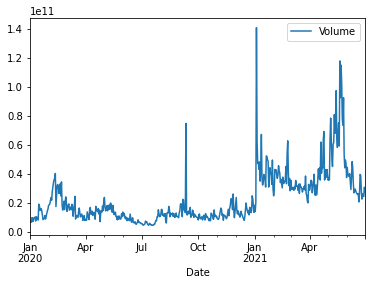

In [80]:
eth.plot()

The line plot illustrates that, *in general* the Volume transactions of Ethereum in June 2021 has increased since January 2020. But if we look further, Ethereum trade Volume had actually drop a bit between the incremental rise in February 2020 and December 2020, then it took a violent spike up at January 2021 that then stabilized for sometimes until another more gradual upward spike at May 2021. 

Based on this graph, I conclude that Ethereum is a relatively volatile market that is still growing and probably offers higher risks and higher returns to those that wish to participate in Crypto Trading. 